# Configs and Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import (
    VotingClassifier, 
    StackingClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    ExtraTreesClassifier, 
    HistGradientBoostingClassifier
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
N_FOLDS = 5
TARGET = 'Target'
SEED = 27

# Loading and Combining the Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]
for feature in cat_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [5]:
label_encoder = LabelEncoder()

X = train.drop(TARGET, axis=1)
y = label_encoder.fit_transform(train[TARGET])

# Training

In [6]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')
        
        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)
            
            y_pred_probs = self.model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)
            
            oof_preds[val_idx] = y_pred_probs
            
            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)
            
            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')
            
        print(f'\n--- Accuracy: {np.mean(accs):.6f} +/- {np.std(accs):.6f}')
        print(f'--- AUC: {np.mean(aucs):.6f} +/- {np.std(aucs):.6f}\n\n')
        
        return self.model, oof_preds, accs, aucs

In [7]:
xgb_params = {
    'booster':"gbtree",
    'colsample_bylevel':0.7560738963204121,
    'colsample_bynode':0.8716441141107502,
    'colsample_bytree':0.5042778021758046,
    'gamma':0.9945128727462176,
    'max_bin':119,
    'max_delta_step':0.23098211569312244,
    'max_depth':20,
    'max_leaves':125,
    'min_child_weight':3.3730244661490936,
    'n_estimators':1656,
    'n_jobs':-1,
    'random_state':27,
    'reg_alpha':6.998479527444306,
    'reg_lambda':3.469046511631597,
    'subsample':0.7842833847777618,
    'verbosity':0,
    'enable_categorical': True
}

cb_params = {
    'bootstrap_type':"MVS",
    'border_count':215,
    'colsample_bylevel':0.5134925027262174,
    'depth':8,
    'grow_policy':"Depthwise",
    'iterations':1973,
    'l2_leaf_reg':8.92208095420847,
    'min_child_samples':97,
    'random_state':27,
    'random_strength':0.5868186074909725,
    'thread_count':-1,
    'verbose': 0,
}

lgbm_params = {
    'colsample_bytree':0.1831360090081373,
    'max_depth':98,
    'min_child_samples':132,
    'min_child_weight':0.2661804600630093,
    'n_estimators':265,
    'n_jobs':-1,
    'num_leaves':23,
    'random_state':27,
    'reg_alpha':0.8824582996601021,
    'reg_lambda':0.5937828270900566,
    'subsample':0.9758185502895064,
    'subsample_freq':5,
    'verbose':-1
}

In [8]:
accuracies = {}
aucs = {}
oof_preds = {}
test_preds = {}

In [9]:
xgb_model = XGBClassifier(**xgb_params)
xgb_model, xgb_oof_preds, xgb_accs, xgb_aucs = Trainer(xgb_model).fit(X, y)
test_preds['XGB'] = xgb_model.predict_proba(test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs
oof_preds['XGB'] = xgb_oof_preds

cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_model, cb_oof_preds, cb_accs, cb_aucs = Trainer(cb_model).fit(X, y)
test_preds['CB'] = cb_model.predict_proba(test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs
oof_preds['CB'] = cb_oof_preds

lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model, lgbm_oof_preds, lgbm_accs, lgbm_aucs = Trainer(lgbm_model).fit(X, y)
test_preds['LGBM'] = lgbm_model.predict_proba(test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs
oof_preds['LGBM'] = lgbm_oof_preds

Training XGBClassifier
--- Fold 1 - Accuracy: 0.832462, AUC: 0.929647
--- Fold 2 - Accuracy: 0.833704, AUC: 0.931299
--- Fold 3 - Accuracy: 0.832135, AUC: 0.928844
--- Fold 4 - Accuracy: 0.832059, AUC: 0.929288
--- Fold 5 - Accuracy: 0.824610, AUC: 0.922982

--- Accuracy: 0.830994 +/- 0.003246
--- AUC: 0.928412 +/- 0.002839


Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.834618, AUC: 0.929775
--- Fold 2 - Accuracy: 0.835860, AUC: 0.931607
--- Fold 3 - Accuracy: 0.833965, AUC: 0.928649
--- Fold 4 - Accuracy: 0.831602, AUC: 0.928998
--- Fold 5 - Accuracy: 0.825002, AUC: 0.923806

--- Accuracy: 0.832209 +/- 0.003861
--- AUC: 0.928567 +/- 0.002591


Training LGBMClassifier
--- Fold 1 - Accuracy: 0.835795, AUC: 0.931021
--- Fold 2 - Accuracy: 0.834814, AUC: 0.932930
--- Fold 3 - Accuracy: 0.835664, AUC: 0.929982
--- Fold 4 - Accuracy: 0.834019, AUC: 0.929920
--- Fold 5 - Accuracy: 0.826635, AUC: 0.924602

--- Accuracy: 0.833386 +/- 0.003435
--- AUC: 0.929691 +/- 0.002767




In [10]:
estimators = [
    ('XGB', xgb_model),
    ('CB', cb_model),
    ('LGBM', lgbm_model)
]

voting_model = VotingClassifier(estimators=estimators, voting='soft')
voting_model, voting_oof_preds, voting_accs, voting_aucs = Trainer(voting_model).fit(X, y)
accuracies['Voting'] = voting_accs
aucs['Voting'] = voting_aucs
oof_preds['Voting'] = voting_oof_preds

Training VotingClassifier
--- Fold 1 - Accuracy: 0.835403, AUC: 0.931414
--- Fold 2 - Accuracy: 0.836317, AUC: 0.933177
--- Fold 3 - Accuracy: 0.835337, AUC: 0.930486
--- Fold 4 - Accuracy: 0.835588, AUC: 0.930577
--- Fold 5 - Accuracy: 0.827485, AUC: 0.925032

--- Accuracy: 0.834026 +/- 0.003289
--- AUC: 0.930137 +/- 0.002729




In [11]:
voting_model_2 = VotingClassifier(estimators=estimators, voting='soft', weights=[0.27602774, 0.41305755, 0.31091472])
voting_model_2, voting_oof_preds_2, voting_accs_2, voting_aucs_2 = Trainer(voting_model_2).fit(X, y)
accuracies['Voting 2'] = voting_accs_2
aucs['Voting 2'] = voting_aucs_2
oof_preds['Voting 2'] = voting_oof_preds_2

Training VotingClassifier
--- Fold 1 - Accuracy: 0.835991, AUC: 0.931370
--- Fold 2 - Accuracy: 0.836775, AUC: 0.933126
--- Fold 3 - Accuracy: 0.835991, AUC: 0.930439
--- Fold 4 - Accuracy: 0.835392, AUC: 0.930512
--- Fold 5 - Accuracy: 0.827746, AUC: 0.925052

--- Accuracy: 0.834379 +/- 0.003345
--- AUC: 0.930100 +/- 0.002703




In [12]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

# Results

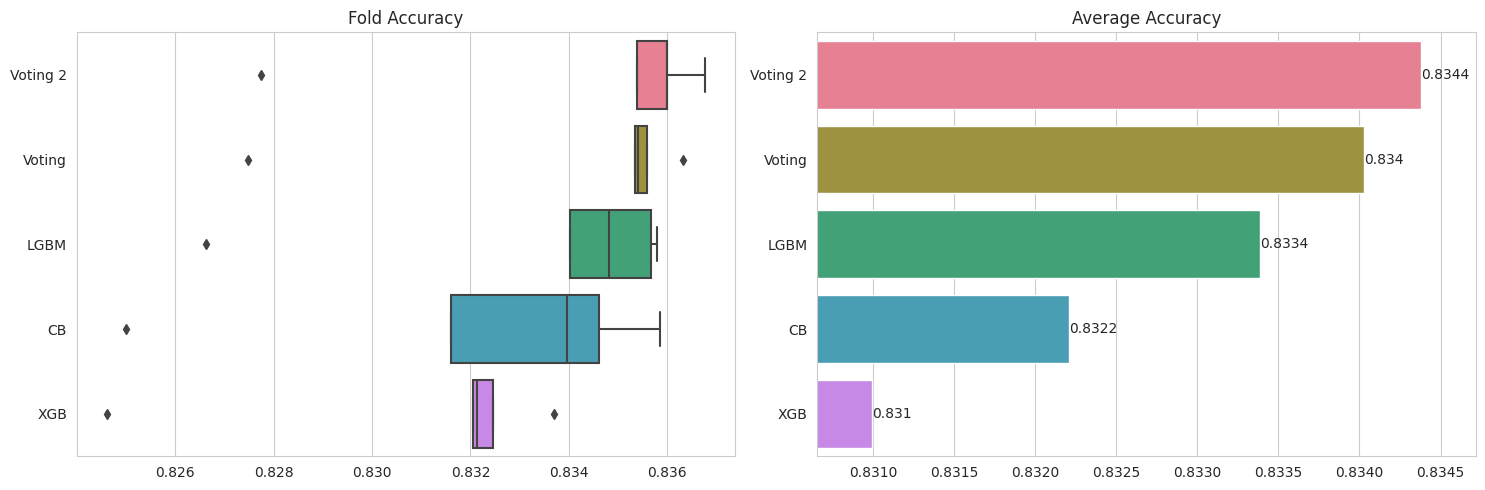

In [13]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

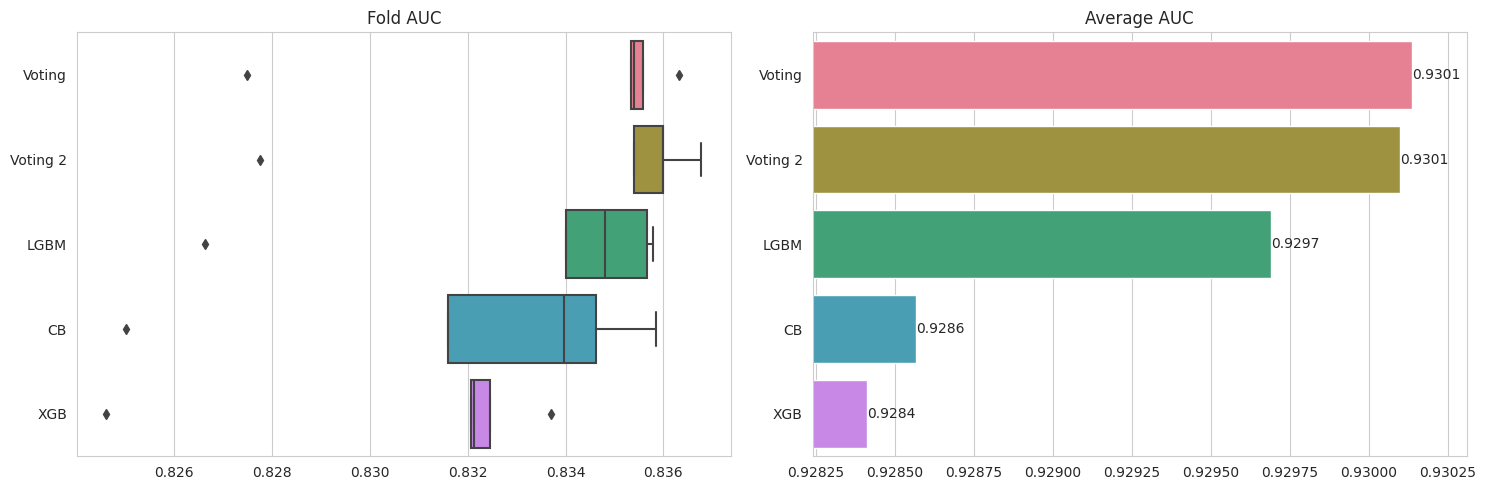

In [14]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

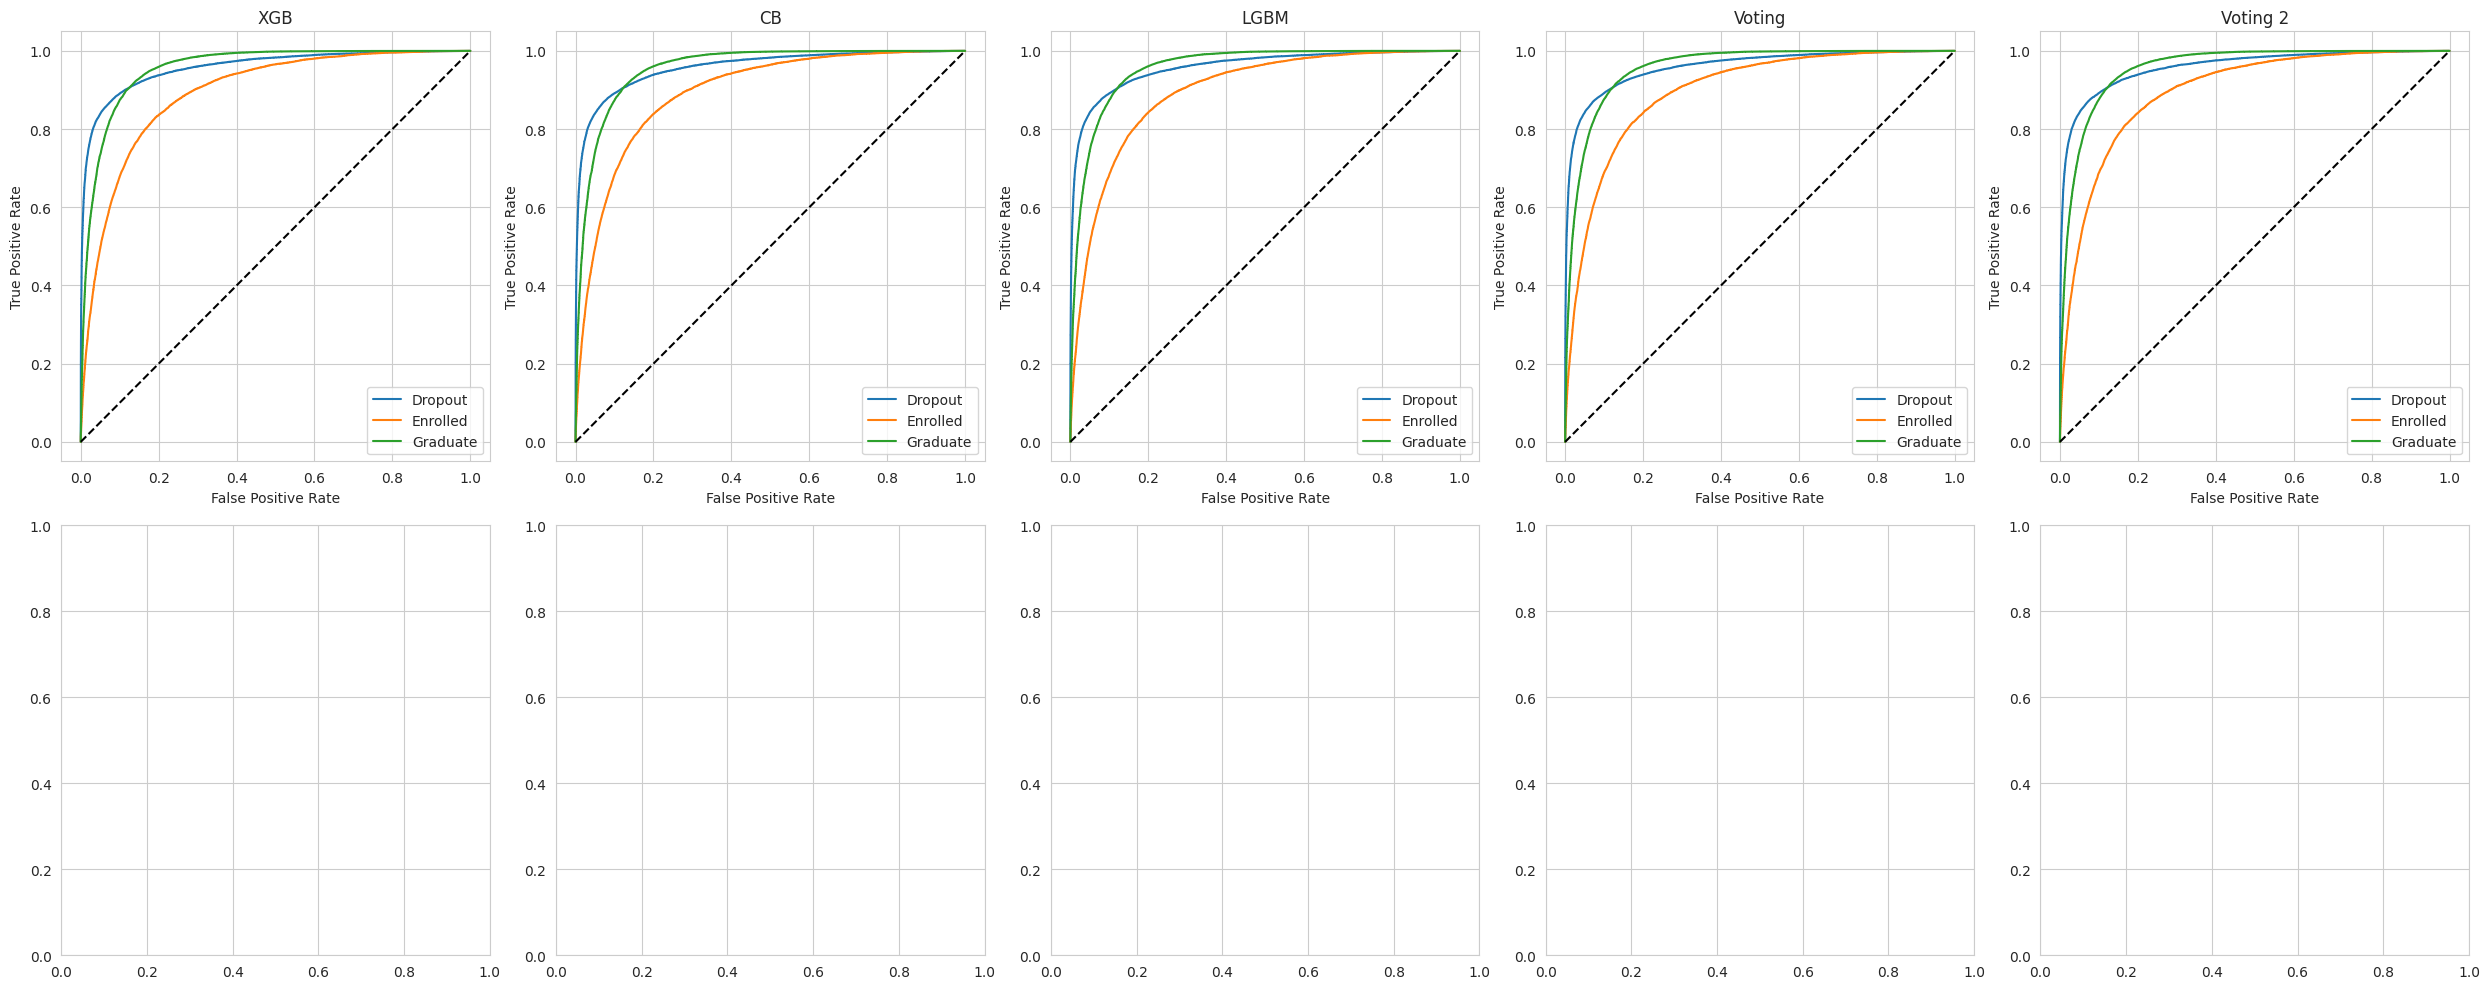

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (model, preds) in zip(axs.flatten(), oof_preds.items()):
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(y, preds[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')
        
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

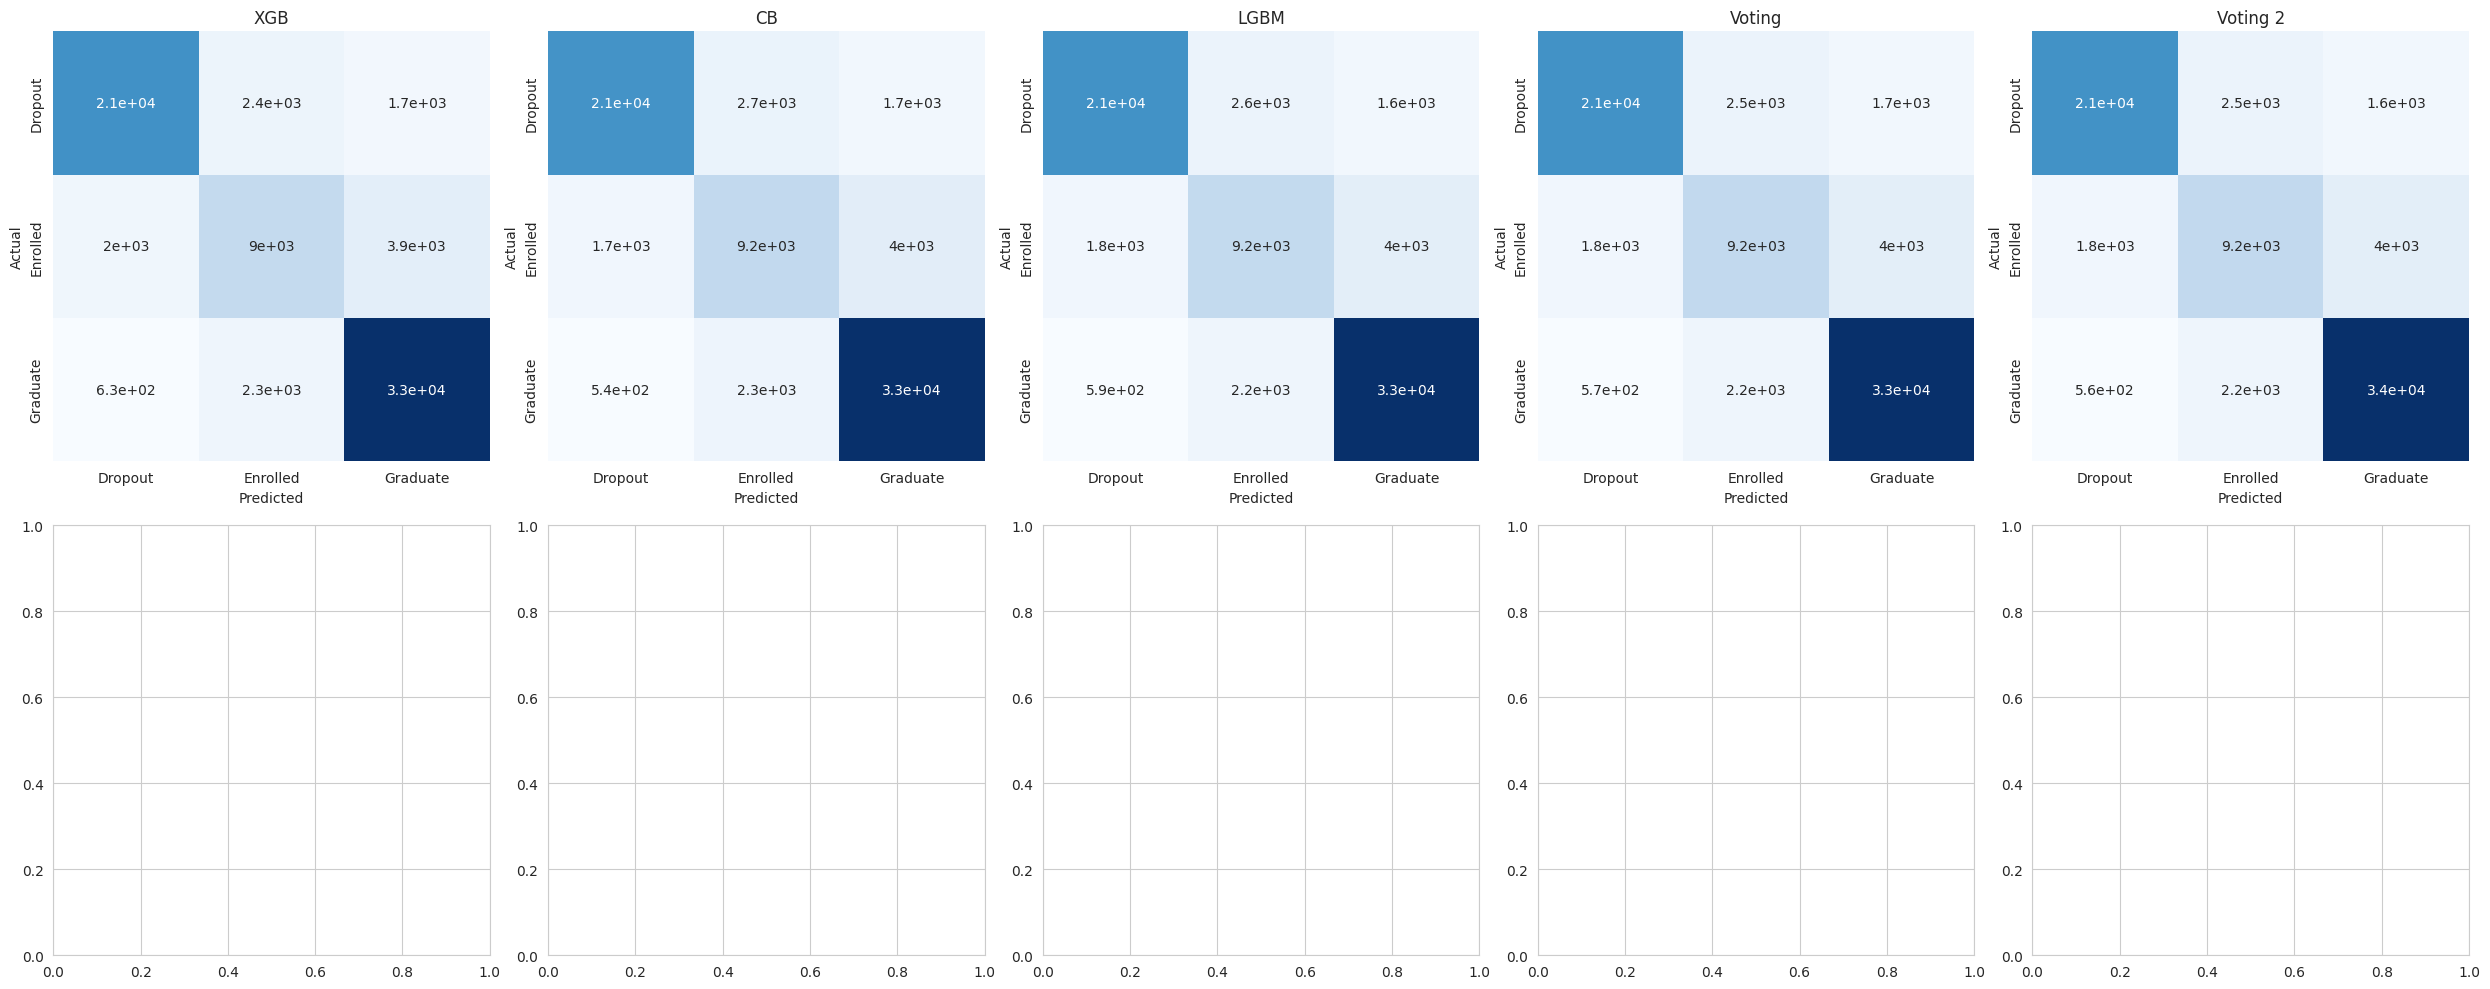

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (model, preds) in zip(axs.flatten(), oof_preds.items()):
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [17]:
for model, preds in test_preds.items():
    submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
    submission['Target'] = np.argmax(preds, axis=1)
    submission['Target'] = label_encoder.inverse_transform(submission['Target'])
    submission.to_csv(f'{model}_acc-{mean_accs[model]:.6f}_auc-{mean_aucs[model]:.6f}.csv', index=False)